In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ============================================================
# CELL 1: IMPORTS AND LOGGING SETUP
# ============================================================
import os
import sys
import json
import csv
import re
import time
import logging
from pathlib import Path
from datetime import datetime
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Project root
ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(ROOT))

# ============================================================
# LOGGING CONFIGURATION
# ============================================================
from src.utils.logging_config import Colors, setup_notebook_logging

# Configuration - CHANGE THESE AS NEEDED
EXPERIMENT_NAME = 'hisir19_pipeline'
DEBUG_CONSOLE = False  # Set to True to show DEBUG logs in console
LOG_DIR = ROOT / 'experiments' / 'hisir19' / 'logs'

# Setup notebook logging (DEBUG always goes to file, console level configurable)
logger = setup_notebook_logging(
    experiment_name=EXPERIMENT_NAME,
    log_dir=str(LOG_DIR),
    debug=DEBUG_CONSOLE
)


# Print colored header
def print_header(title: str, subtitle: str = None):
    """Print a colored header for the notebook."""
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_GREEN}🏛️ {title}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')
    logging.info(f'{Colors.CYAN}📅 Date:{Colors.RESET} {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    logging.info(f'{Colors.CYAN}📂 Project Root:{Colors.RESET} {ROOT}')
    logging.info(f'{Colors.CYAN}📁 Log Directory:{Colors.RESET} {LOG_DIR}')
    logging.info(f'{Colors.CYAN}📜 Log File:{Colors.RESET} {logger.log_file}')
    logging.info(f'{Colors.CYAN}🔧 Debug Console:{Colors.RESET} {DEBUG_CONSOLE}')
    device_str = "CUDA" if torch.cuda.is_available() else "CPU"
    logging.info(f'{Colors.CYAN}🖥️  Device:{Colors.RESET} {device_str}')
    if torch.cuda.is_available():
        logging.info(f'{Colors.GRAY}   GPU: {torch.cuda.get_device_name(0)}{Colors.RESET}')
        logging.info(
            f'{Colors.GRAY}   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB{Colors.RESET}')
    if subtitle:
        logging.info(f'{Colors.YELLOW}{subtitle}{Colors.RESET}')
    logging.info(f'{Colors.BOLD_CYAN}{"=" * 70}{Colors.RESET}')


print_header(
    'HISIR19 HISTORICAL WRITER RETRIEVAL - COMPLETE PIPELINE',
    subtitle='📜 ICDAR 2019 Competition on Image Retrieval for Historical Documents'
)

10:06:37 | INFO     | ℹ️  
══════════════════════════════════════════════════════════════════════
10:06:37 | INFO     | ℹ️                            🚀 HISIR19_PIPELINE                          
10:06:37 | INFO     | ℹ️  ══════════════════════════════════════════════════════════════════════
10:06:37 | INFO     | 📁 Log file: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/hisir19/logs/hisir19_pipeline_20251207_100637.log
10:06:37 | INFO     | ℹ️  🕐 Started: 2025-12-07 10:06:37
10:06:37 | INFO     | ℹ️  ──────────────────────────────────────────────────────────────────────
10:06:37 | INFO     | ℹ️  ======================================================================
10:06:37 | INFO     | ℹ️  🏛️ HISIR19 HISTORICAL WRITER RETRIEVAL - COMPLETE PIPELINE
10:06:37 | INFO     | ℹ️  ======================================================================
10:06:37 | INFO     | ℹ️  📅 Date: 2025-12-07 10:06:37
10:06:37 | INFO     | ℹ️  📂 Project Root: /home/spark/NUST/Semester

In [3]:
# ============================================================
# CELL 2: PROJECT IMPORTS
# ============================================================
logger.info(Colors.CYAN + '\n📦 Loading project modules...' + Colors.RESET)

# Training - Patch Level
from src.train.train_resnet_triplet import main as train_resnet_triplet
from src.train.fit_vlad_centers import main as fit_vlad_centers
from src.train.patch_dataset import PatchDataset
from src.train.triplet_loss import get_loss_function
from src.train.samplers import MPerClassSampler
from src.train.augmentation import get_train_augmentation

# Training - End-to-End (RECOMMENDED)
from src.train.page_bag_dataset import PageBagDataset, create_page_dataloader
from src.models.e2e_writer_net import EndToEndWriterNet

# Features
from src.features.resnet_patch_extractor import create_resnet_patch_encoder
from src.sampling.adaptive_sampler import AdaptiveSamplingConfig

# Evaluation
from src.evaluation.eval_retrieval import main as eval_retrieval
from src.evaluation.metrics import mean_average_precision
from src.evaluation.retrieval_engine import (
    extract_descriptors, fit_pca_whitening, apply_pca_whitening, RetrievalConfig
)

# Reranking
from src.reranking.sgr import apply_sgr
from src.reranking.sgr_plus import apply_sgr_plus

# Utils
from src.utils.preprocessing import load_image, binarize_otsu

logger.info(Colors.GREEN + '✅ All modules loaded successfully!' + Colors.RESET)

10:06:40 | INFO     | ℹ️  
📦 Loading project modules...
10:06:41 | INFO     | ℹ️  ✅ All modules loaded successfully!


In [7]:
# ============================================================
# CELL 3: PATH CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n📂 Configuring paths...' + Colors.RESET)

# Data directories
DATA_DIR = ROOT / 'data'
HISIR19_TEST_DIR = DATA_DIR / 'HISIR19'  # 20,000 test images
HISIR19_VAL_DIR = DATA_DIR / 'HISIR19-Valdidation'  # 1,200 validation images  
HISIR19_META_DIR = DATA_DIR / 'HISIR19-Meta'  # Metadata files

# Metadata files
VAL_WRITERS_CSV = HISIR19_VAL_DIR / 'writers.csv'
TEST_GROUND_TRUTH = HISIR19_META_DIR / 'wi_comp19_test_ground_truth.csv'

# Output directories
EXPERIMENTS_DIR = ROOT / 'experiments'
CHECKPOINTS_DIR = EXPERIMENTS_DIR / 'hisir19' / 'checkpoints'
RESULTS_DIR = EXPERIMENTS_DIR / 'hisir19' / 'results'
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# CSV files we'll create
HISIR19_VAL_CSV = EXPERIMENTS_DIR / 'hisir19' / 'hisir19_val.csv'
HISIR19_TEST_CSV = EXPERIMENTS_DIR / 'hisir19' / 'hisir19_test.csv'
HISIR19_TRAIN_CSV = EXPERIMENTS_DIR / 'hisir19' / 'hisir19_train.csv'  # Subset of validation for training

logger.info(Colors.CYAN + f'   Test images: {HISIR19_TEST_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Validation images: {HISIR19_VAL_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Metadata: {HISIR19_META_DIR}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Results: {RESULTS_DIR}' + Colors.RESET)
logger.info('')

# Verify paths
paths_ok = True
for p, name in [
    (HISIR19_TEST_DIR, 'Test directory'),
    (HISIR19_VAL_DIR, 'Validation directory'),
    (VAL_WRITERS_CSV, 'Validation writers.csv'),
    (TEST_GROUND_TRUTH, 'Test ground truth'),
]:
    if p.exists():
        logger.info(Colors.GREEN + f'   ✅ {name}' + Colors.RESET)
    else:
        logger.error(Colors.RED + f'   ❌ {name} NOT FOUND: {p}' + Colors.RESET)
        paths_ok = False

if paths_ok:
    logger.info(Colors.GREEN + '\n✅ All paths verified!' + Colors.RESET)
else:
    logger.warning(Colors.YELLOW + '\n⚠️ Some paths are missing!' + Colors.RESET)

10:07:15 | INFO     | ℹ️  
📂 Configuring paths...
10:07:15 | INFO     | ℹ️     Test images: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/HISIR19
10:07:15 | INFO     | ℹ️     Validation images: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/HISIR19-Valdidation
10:07:15 | INFO     | ℹ️     Metadata: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/data/HISIR19-Meta
10:07:15 | INFO     | ℹ️     Results: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/hisir19/results
10:07:15 | INFO     | ℹ️  
10:07:15 | INFO     | ℹ️     ✅ Test directory
10:07:15 | INFO     | ℹ️     ✅ Validation directory
10:07:15 | INFO     | ℹ️     ✅ Validation writers.csv
10:07:15 | INFO     | ℹ️     ✅ Test ground truth
10:07:15 | INFO     | ℹ️  
✅ All paths verified!


In [4]:
# ============================================================
# CELL 4: CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n⚙️ Setting configuration...' + Colors.RESET)

HISIR19_CONFIG = {
    'backbone': 'resnet34',  # Options: 'small', 'small_deep', 'resnet18', 'resnet34'
    # Training
    'batch_size': 64,
    'lr': 3e-4,
    'epochs': 30,
    'emb_dim': 128,
    'patch_size': 32,
    'm_per_class': 4,  # Samples per writer in triplet mining
    'warmup_epochs': 3,  # Warmup epochs
    'patience': 7,  # Early stopping patience
    'grad_clip': 2.0,  # Gradient clipping

    # Sampling
    'sampler_mode': 'contour',  # Options: 'dense', 'contour', 'adaptive', 'char'
    'max_patches': 1500,
    'dense_stride': 24,
    'contour_step': 12,

    # Aggregation
    'agg_type': 'netrvlad',  # Best for historical documents
    'num_clusters': 100,

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Training split (from validation set)
    'train_ratio': 0.8,  # 80% of validation for training, 20% for val
}

logger.info(Colors.CYAN + '   Configuration:' + Colors.RESET)
for k, v in HISIR19_CONFIG.items():
    logger.info(Colors.CYAN + f'      {k}: {v}' + Colors.RESET)

10:06:42 | INFO     | ℹ️  
⚙️ Setting configuration...
10:06:42 | INFO     | ℹ️     Configuration:
10:06:42 | INFO     | ℹ️        backbone: resnet34
10:06:42 | INFO     | ℹ️        batch_size: 64
10:06:42 | INFO     | ℹ️        lr: 0.0003
10:06:42 | INFO     | ℹ️        epochs: 30
10:06:42 | INFO     | ℹ️        emb_dim: 128
10:06:42 | INFO     | ℹ️        patch_size: 32
10:06:42 | INFO     | ℹ️        m_per_class: 4
10:06:42 | INFO     | ℹ️        warmup_epochs: 3
10:06:42 | INFO     | ℹ️        patience: 7
10:06:42 | INFO     | ℹ️        grad_clip: 2.0
10:06:42 | INFO     | ℹ️        sampler_mode: contour
10:06:42 | INFO     | ℹ️        max_patches: 1500
10:06:42 | INFO     | ℹ️        dense_stride: 24
10:06:42 | INFO     | ℹ️        contour_step: 12
10:06:42 | INFO     | ℹ️        agg_type: netrvlad
10:06:42 | INFO     | ℹ️        num_clusters: 100
10:06:42 | INFO     | ℹ️        device: cuda
10:06:42 | INFO     | ℹ️        train_ratio: 0.8


## Step 1: Data Preparation

Prepare CSV files for the HISIR19 dataset:
- Validation set (1,200 images) → Split into train/val for model training
- Test set (20,000 images) → Final evaluation

In [21]:
# ============================================================
# CELL 5: PREPARE VALIDATION CSV
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📋 STEP 1: DATA PREPARATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Read validation writers.csv
logger.info(Colors.CYAN + '\n📖 Reading validation writers.csv...' + Colors.RESET)
val_data = []
with open(VAL_WRITERS_CSV, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            filename, writer_id = parts[0], parts[1]
            img_path = HISIR19_VAL_DIR / filename
            if img_path.exists():
                val_data.append({
                    'image_path': str(img_path),
                    'writer_id': int(writer_id),
                    'filename': filename
                })

val_df = pd.DataFrame(val_data)
logger.info(Colors.CYAN + f'   Total validation images: {len(val_df)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Unique writers: {val_df["writer_id"].nunique()}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Images per writer: {len(val_df) / val_df["writer_id"].nunique():.1f} avg' + Colors.RESET)

10:54:35 | INFO     | ℹ️  
10:54:35 | INFO     | ℹ️  📋 STEP 1: DATA PREPARATION
10:54:35 | INFO     | ℹ️  ======================================================================
10:54:35 | INFO     | ℹ️  
📖 Reading validation writers.csv...
10:54:35 | INFO     | ℹ️     Total validation images: 1200
10:54:35 | INFO     | ℹ️     Unique writers: 520
10:54:35 | INFO     | ℹ️     Images per writer: 2.3 avg


In [22]:
# ============================================================
# CELL 6: SPLIT VALIDATION INTO TRAIN/VAL
# ============================================================
logger.info(Colors.CYAN + '\n📊 Splitting validation set into train/val...' + Colors.RESET)

# Group by writer and split
writers = val_df['writer_id'].unique()
np.random.seed(42)
np.random.shuffle(writers)

n_train_writers = int(len(writers) * HISIR19_CONFIG['train_ratio'])
train_writers = set(writers[:n_train_writers])
val_writers = set(writers[n_train_writers:])

train_df = val_df[val_df['writer_id'].isin(train_writers)].copy()
val_split_df = val_df[val_df['writer_id'].isin(val_writers)].copy()

logger.info(Colors.CYAN + f'\n   Training set:' + Colors.RESET)
logger.info(Colors.CYAN + f'      Writers: {len(train_writers)}' + Colors.RESET)
logger.info(Colors.CYAN + f'      Images: {len(train_df)}' + Colors.RESET)
logger.info(Colors.CYAN + f'\n   Validation set:' + Colors.RESET)
logger.info(Colors.CYAN + f'      Writers: {len(val_writers)}' + Colors.RESET)
logger.info(Colors.CYAN + f'      Images: {len(val_split_df)}' + Colors.RESET)

# Save CSVs
train_df[['image_path', 'writer_id']].to_csv(HISIR19_TRAIN_CSV, index=False)
val_split_df[['image_path', 'writer_id']].to_csv(HISIR19_VAL_CSV, index=False)

logger.info(Colors.GREEN + f'\n   💾 Saved: {HISIR19_TRAIN_CSV.name}' + Colors.RESET)
logger.info(Colors.GREEN + f'   💾 Saved: {HISIR19_VAL_CSV.name}' + Colors.RESET)

10:54:37 | INFO     | ℹ️  
📊 Splitting validation set into train/val...
10:54:37 | INFO     | ℹ️  
   Training set:
10:54:37 | INFO     | ℹ️        Writers: 416
10:54:37 | INFO     | ℹ️        Images: 968
10:54:37 | INFO     | ℹ️  
   Validation set:
10:54:37 | INFO     | ℹ️        Writers: 104
10:54:37 | INFO     | ℹ️        Images: 232
10:54:37 | INFO     | ℹ️  
   💾 Saved: hisir19_train.csv
10:54:37 | INFO     | ℹ️     💾 Saved: hisir19_val.csv


In [16]:
# ============================================================
# CELL 7: PREPARE TEST CSV
# ============================================================
logger.info(Colors.CYAN + '\n📖 Preparing test set CSV...' + Colors.RESET)

# Read test ground truth
test_data = []
with open(TEST_GROUND_TRUTH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filename = row['FILENEMA']  # Note: typo in original dataset
        writer_id = row['ID']
        source = row.get('SOURCE', 'unknown')
        img_path = HISIR19_TEST_DIR / filename
        if img_path.exists():
            test_data.append({
                'image_path': str(img_path),
                'writer_id': int(writer_id),
                'source': source,
                'filename': filename
            })

test_df = pd.DataFrame(test_data)
logger.info(Colors.CYAN + f'   Total test images: {len(test_df)}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Unique writers: {test_df["writer_id"].nunique()}' + Colors.RESET)

# Show category distribution
logger.info(Colors.CYAN + '\n   Category distribution:' + Colors.RESET)
for cat, count in test_df['source'].value_counts().items():
    logger.info(Colors.CYAN + f'      {cat}: {count} images' + Colors.RESET)

# Save test CSV
test_df[['image_path', 'writer_id']].to_csv(HISIR19_TEST_CSV, index=False)
logger.info(Colors.GREEN + f'\n   💾 Saved: {HISIR19_TEST_CSV.name}' + Colors.RESET)

10:19:30 | INFO     | ℹ️  
📖 Preparing test set CSV...
10:19:30 | INFO     | ℹ️     Total test images: 20000
10:19:30 | INFO     | ℹ️     Unique writers: 10069
10:19:30 | INFO     | ℹ️  
   Category distribution:
10:19:30 | INFO     | ℹ️        manuscripts: 10135 images
10:19:30 | INFO     | ℹ️        charters: 5158 images
10:19:30 | INFO     | ℹ️        fau: 2655 images
10:19:30 | INFO     | ℹ️        basel: 2052 images
10:19:30 | INFO     | ℹ️  
   💾 Saved: hisir19_test.csv


23:45:25 | INFO     | ℹ️  
🖼️ Visualizing sample images...


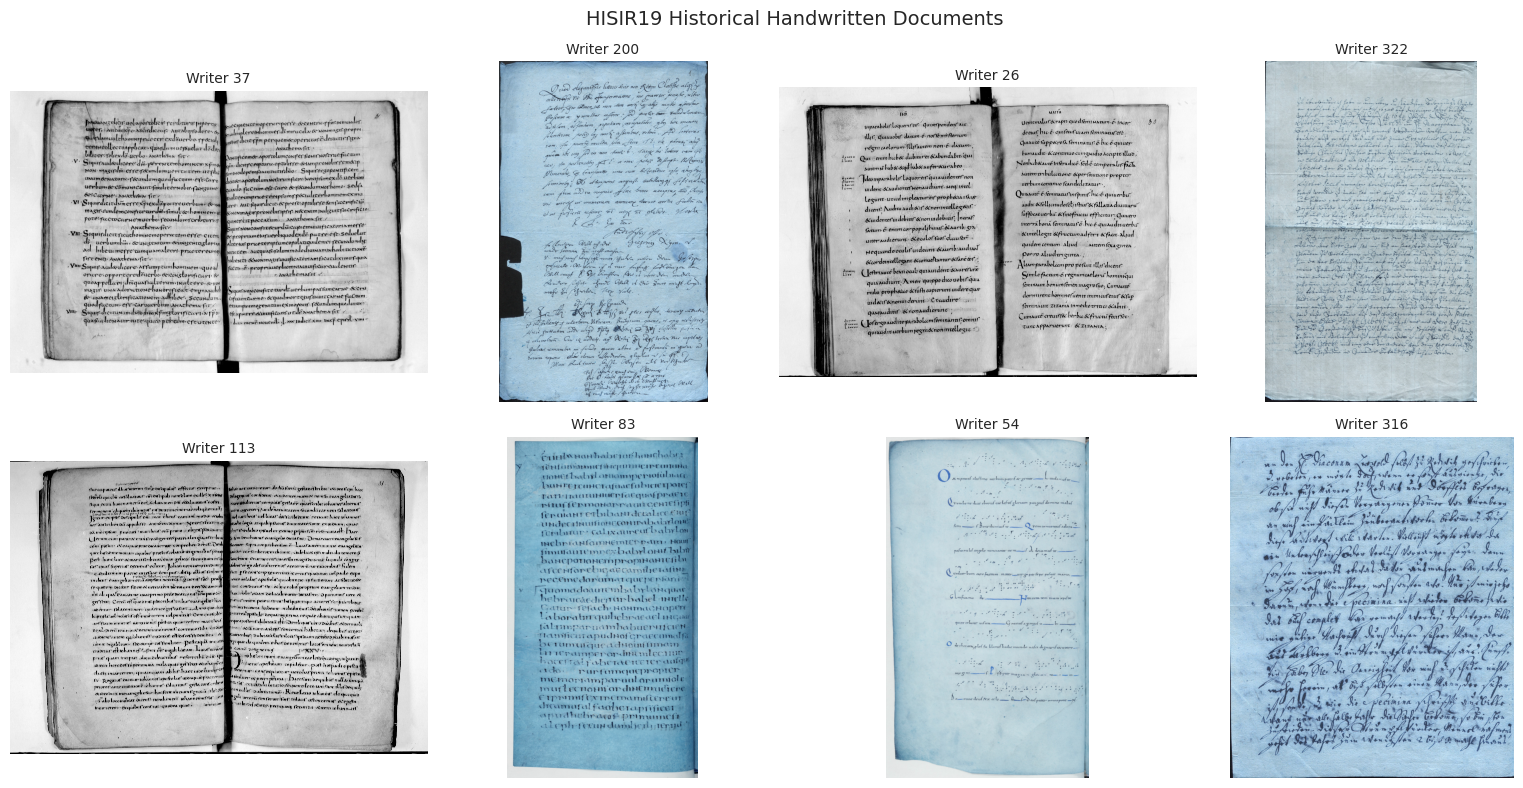

23:45:38 | INFO     | ℹ️     💾 Saved sample visualization


In [10]:
# ============================================================
# CELL 8: VISUALIZE SAMPLE IMAGES
# ============================================================
logger.info(Colors.CYAN + '\n🖼️ Visualizing sample images...' + Colors.RESET)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('HISIR19 Historical Handwritten Documents', fontsize=14)

# Sample from validation
sample_images = train_df.sample(n=8, random_state=42)

for idx, (ax, (_, row)) in enumerate(zip(axes.flat, sample_images.iterrows())):
    try:
        img = load_image(row['image_path'])
        if img is not None:
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            ax.set_title(f'Writer {row["writer_id"]}', fontsize=10)
        else:
            ax.set_title('Load Error', fontsize=10)
    except Exception as e:
        ax.set_title(f'Error: {str(e)[:20]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'hisir19_sample_images.png', dpi=150)
plt.show()
logger.info(Colors.GREEN + '   💾 Saved sample visualization' + Colors.RESET)

## Step 2: Model Training

Train the ResNet patch encoder using triplet loss on the training split.

In [11]:
# ============================================================
# CELL 9: TRAINING CONFIGURATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🏋️ STEP 2: MODEL TRAINING' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Check for existing checkpoint
existing_ckpts = sorted(CHECKPOINTS_DIR.glob('best_*.pt'),
                        key=lambda x: x.stat().st_mtime, reverse=True)

if existing_ckpts:
    logger.info(Colors.CYAN + f'\n📁 Found {len(existing_ckpts)} existing checkpoints' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Latest: {existing_ckpts[0].name}' + Colors.RESET)
    USE_EXISTING = True
    best_ckpt = existing_ckpts[0]
else:
    logger.warning(Colors.YELLOW + '\n⚠️ No existing checkpoints found' + Colors.RESET)
    USE_EXISTING = False
    best_ckpt = None

# Training parameters (using correct argument names for train_resnet_triplet.py)
train_args = {
    'csv': str(HISIR19_TRAIN_CSV),
    'root_dir': str(ROOT),
    'save_dir': str(CHECKPOINTS_DIR),
    'val_split': 0.1,
    'epochs': HISIR19_CONFIG['epochs'],
    'batch_size': HISIR19_CONFIG['batch_size'],
    'lr': HISIR19_CONFIG['lr'],
    'emb_dim': HISIR19_CONFIG['emb_dim'],
    'm_per_class': HISIR19_CONFIG['m_per_class'],
    'sampler': HISIR19_CONFIG['sampler_mode'],
    'device': HISIR19_CONFIG['device'],
    'patience': HISIR19_CONFIG['patience'],
    'grad_clip': HISIR19_CONFIG['grad_clip'],
    'warmup_epochs': HISIR19_CONFIG['warmup_epochs'],
}

logger.info(Colors.CYAN + '\n   Training configuration:' + Colors.RESET)
for k, v in train_args.items():
    logger.info(Colors.CYAN + f'      {k}: {v}' + Colors.RESET)

23:45:38 | INFO     | ℹ️  
23:45:38 | INFO     | ℹ️  🏋️ STEP 2: MODEL TRAINING
23:45:38 | INFO     | ℹ️  ======================================================================
23:45:38 | WARNING  | ⚠️  
⚠️ No existing checkpoints found
23:45:38 | INFO     | ℹ️  
   Training configuration:
23:45:38 | INFO     | ℹ️        csv: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/hisir19/hisir19_train.csv
23:45:38 | INFO     | ℹ️        root_dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR
23:45:38 | INFO     | ℹ️        save_dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/hisir19/checkpoints
23:45:38 | INFO     | ℹ️        val_split: 0.1
23:45:38 | INFO     | ℹ️        epochs: 30
23:45:38 | INFO     | ℹ️        batch_size: 64
23:45:38 | INFO     | ℹ️        lr: 0.0003
23:45:38 | INFO     | ℹ️        emb_dim: 128
23:45:38 | INFO     | ℹ️        m_per_class: 4
23:45:38 | INFO     | ℹ️        sampler: contour
23:45:38 | INFO     | ℹ️

### End-to-End Training Option (RECOMMENDED)

For HISIR19, E2E training is particularly important because:
1. The dataset contains noise and artifacts
2. Character-level sampling is critical for filtering noise
3. Page-level loss learns robust writer features

**USE_E2E_TRAINING = True** is recommended for best results.

In [5]:
# ============================================================
# CELL 9.5: END-TO-END TRAINING CONFIGURATION
# ============================================================
USE_E2E_TRAINING = True  # RECOMMENDED for HISIR19

E2E_CONFIG = {
    **HISIR19_CONFIG,
    # Aggregation
    'agg_type': 'gem',  # GeM works best
    'gem_p': 3.0,

    # Page-level training
    'patches_per_page': 32,
    'batch_size': 16,
    'm_per_class': 2,

    # Training
    'epochs': 50,
    'lr': 1e-4,
    'final_lr': 1e-6,
    'warmup_epochs': 5,
    'margin': 0.1,
    'weight_decay': 1e-5,
    'patience': 15,

    # IMPORTANT: Use char sampling for HISIR19 (filters noise)
    'sampler_mode': 'char',

    # Pretrained (optional)
    'pretrained': None,
}

logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '⚙️  END-TO-END TRAINING CONFIGURATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if USE_E2E_TRAINING:
    logger.info(Colors.GREEN + '\n✅ E2E Training ENABLED (recommended for HISIR19)' + Colors.RESET)
    logger.info(Colors.CYAN + '\n📋 E2E Configuration:' + Colors.RESET)
    for key, value in E2E_CONFIG.items():
        logger.info(Colors.CYAN + f'   {key}: {value}' + Colors.RESET)
else:
    logger.warning(Colors.YELLOW + '\n⚠️  E2E Training DISABLED' + Colors.RESET)

10:06:53 | INFO     | ℹ️  
10:06:53 | INFO     | ℹ️  ⚙️  END-TO-END TRAINING CONFIGURATION
10:06:53 | INFO     | ℹ️  ======================================================================
10:06:53 | INFO     | ℹ️  
✅ E2E Training ENABLED (recommended for HISIR19)
10:06:53 | INFO     | ℹ️  
📋 E2E Configuration:
10:06:53 | INFO     | ℹ️     backbone: resnet34
10:06:53 | INFO     | ℹ️     batch_size: 16
10:06:53 | INFO     | ℹ️     lr: 0.0001
10:06:53 | INFO     | ℹ️     epochs: 50
10:06:53 | INFO     | ℹ️     emb_dim: 128
10:06:53 | INFO     | ℹ️     patch_size: 32
10:06:53 | INFO     | ℹ️     m_per_class: 2
10:06:53 | INFO     | ℹ️     warmup_epochs: 5
10:06:53 | INFO     | ℹ️     patience: 15
10:06:53 | INFO     | ℹ️     grad_clip: 2.0
10:06:53 | INFO     | ℹ️     sampler_mode: char
10:06:53 | INFO     | ℹ️     max_patches: 1500
10:06:53 | INFO     | ℹ️     dense_stride: 24
10:06:53 | INFO     | ℹ️     contour_step: 12
10:06:53 | INFO     | ℹ️     agg_type: gem
10:06:53 | INFO     | ℹ️

In [19]:
# ============================================================
# CELL 9.6: RUN END-TO-END TRAINING
# ============================================================
if USE_E2E_TRAINING:
    logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '🏋️  END-TO-END TRAINING' + Colors.RESET)
    logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

    from src.train.train_e2e import main as train_e2e

    e2e_args = [
        '--csv', str(HISIR19_TRAIN_CSV),
        '--encoder', E2E_CONFIG['backbone'],
        '--root-dir', str(ROOT),
        '--epochs', str(E2E_CONFIG['epochs']),
        '--batch-size', str(E2E_CONFIG['batch_size']),
        '--patches-per-page', str(E2E_CONFIG['patches_per_page']),
        '--agg-type', E2E_CONFIG['agg_type'],
        '--gem-p', str(E2E_CONFIG['gem_p']),
        '--lr', str(E2E_CONFIG['lr']),
        '--final-lr', str(E2E_CONFIG['final_lr']),
        '--warmup-epochs', str(E2E_CONFIG['warmup_epochs']),
        '--margin', str(E2E_CONFIG['margin']),
        '--m-per-class', str(E2E_CONFIG['m_per_class']),
        '--weight-decay', str(E2E_CONFIG['weight_decay']),
        '--emb-dim', str(HISIR19_CONFIG['emb_dim']),
        '--sampler', E2E_CONFIG['sampler_mode'],  # char sampling for HISIR19
        '--device', HISIR19_CONFIG['device'],
        '--patience', str(HISIR19_CONFIG['patience']),
        '--save-dir', str(CHECKPOINTS_DIR),
        '--debug',
        '--cache-patches',
    ]

    if E2E_CONFIG['pretrained']:
        e2e_args.extend(['--pretrained', str(E2E_CONFIG['pretrained'])])

    e2e_args.append('--augment')

    logger.info(Colors.CYAN + '\n📋 E2E Training Arguments:' + Colors.RESET)
    for i in range(0, len(e2e_args), 2):
        if i + 1 < len(e2e_args) and not e2e_args[i + 1].startswith('--'):
            logger.info(Colors.CYAN + f'   {e2e_args[i]}: {e2e_args[i + 1]}' + Colors.RESET)

    logger.info(Colors.MAGENTA + '\n🚀 Starting End-to-End training...' + Colors.RESET)
    logger.info(Colors.MAGENTA + '   📍 Using CHAR sampling to filter noise!' + Colors.RESET)
    logger.info('')

    sys.argv = ['train_e2e.py'] + e2e_args
    train_start = time.time()

    try:
        train_e2e()
        train_time = time.time() - train_start
        logger.info(Colors.GREEN + f'\n✅ E2E Training complete in {train_time / 60:.1f} minutes!' + Colors.RESET)

        # Update best_ckpt
        encoder_ckpts = sorted(CHECKPOINTS_DIR.glob('encoder_*.pt'),
                               key=lambda x: x.stat().st_mtime, reverse=True)
        if encoder_ckpts:
            best_ckpt = encoder_ckpts[0]
    except Exception as e:
        logger.error(Colors.RED + f'\n❌ E2E Training failed: {e}' + Colors.RESET)
        raise
else:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping E2E training' + Colors.RESET)

23:49:39 | INFO     | ℹ️  
23:49:39 | INFO     | ℹ️  🏋️  END-TO-END TRAINING
23:49:39 | INFO     | ℹ️  ======================================================================
23:49:39 | INFO     | ℹ️  
📋 E2E Training Arguments:
23:49:39 | INFO     | ℹ️     --csv: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/hisir19/hisir19_train.csv
23:49:39 | INFO     | ℹ️     --encoder: resnet34
23:49:39 | INFO     | ℹ️     --root-dir: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR
23:49:39 | INFO     | ℹ️     --epochs: 50
23:49:39 | INFO     | ℹ️     --batch-size: 16
23:49:39 | INFO     | ℹ️     --patches-per-page: 32
23:49:39 | INFO     | ℹ️     --agg-type: gem
23:49:39 | INFO     | ℹ️     --gem-p: 3.0
23:49:39 | INFO     | ℹ️     --lr: 0.0001
23:49:39 | INFO     | ℹ️     --final-lr: 1e-06
23:49:39 | INFO     | ℹ️     --warmup-epochs: 5
23:49:39 | INFO     | ℹ️     --margin: 0.1
23:49:39 | INFO     | ℹ️     --m-per-class: 2
23:49:39 | INFO     | ℹ️     --weight-de

In [20]:
# ============================================================
# CELL 10: RUN PATCH-LEVEL TRAINING (ALTERNATIVE TO E2E)
# ============================================================
if USE_E2E_TRAINING:
    logger.info(Colors.YELLOW + '\n⏭️  Skipping patch-level training (E2E training was used)' + Colors.RESET)
else:
    TRAIN_NEW_MODEL = True  # Set to True to train from scratch

    if TRAIN_NEW_MODEL and not USE_EXISTING:
        logger.info(Colors.MAGENTA + '\n🚀 Starting patch-level training...' + Colors.RESET)
        logger.warning(Colors.YELLOW + '   ⚠️  Consider using E2E training for better results.' + Colors.RESET)

        # Build command line args
        sys.argv = ['train_resnet_triplet.py',
                    '--csv', train_args['csv'],
                    '--root-dir', train_args['root_dir'],
                    '--save-dir', train_args['save_dir'],
                    '--val-split', str(train_args['val_split']),
                    '--epochs', str(train_args['epochs']),
                    '--batch-size', str(train_args['batch_size']),
                    '--lr', str(train_args['lr']),
                    '--emb-dim', str(train_args['emb_dim']),
                    '--m-per-class', str(train_args['m_per_class']),
                    '--sampler', train_args['sampler'],
                    '--device', train_args['device'],
                    '--patience', str(train_args['patience']),
                    '--grad-clip', str(train_args['grad_clip']),
                    '--warmup-epochs', str(train_args['warmup_epochs']),
                    '--augment',
                    '--debug',
                    ]

        train_resnet_triplet()

        # Find best checkpoint
        existing_ckpts = sorted(CHECKPOINTS_DIR.glob('best_*.pt'),
                                key=lambda x: x.stat().st_mtime, reverse=True)
        best_ckpt = existing_ckpts[0] if existing_ckpts else None
        logger.info(Colors.GREEN + f'\n✅ Training complete! Best checkpoint: {best_ckpt}' + Colors.RESET)
    else:
        if best_ckpt:
            logger.info(Colors.GREEN + f'\n✅ Using existing checkpoint: {best_ckpt.name}' + Colors.RESET)
        else:
            logger.warning(
                Colors.YELLOW + '\n⚠️ No checkpoint available. Set TRAIN_NEW_MODEL=True to train.' + Colors.RESET)

00:04:28 | INFO     | ℹ️  
⏭️  Skipping patch-level training (E2E training was used)


In [8]:
# ============================================================
# CELL 9: FIND BEST CHECKPOINT
# ============================================================
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '\n🔍 STEP 4.5: FIND BEST CHECKPOINT' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)
# Find all checkpoints - both E2E and patch-level formats
# E2E checkpoints have encoder_*.pt (just the patch encoder)
# Patch-level checkpoints have best_epoch_*.pt

ckpt_list = list(CHECKPOINTS_DIR.glob('best_epoch*_loss*.pt'))
encoder_list = list(CHECKPOINTS_DIR.glob('encoder_epoch*_loss*.pt'))

if not ckpt_list and not encoder_list:
    # Try notebooks checkpoints as fallback
    ckpt_list = list((ROOT / 'notebooks' / 'checkpoints').glob('best_epoch*_loss*.pt'))


def extract_loss(p):
    m = re.search(r'loss_([0-9.]+)\.pt$', p.name)
    return float(m.group(1)) if m else float('inf')


# For E2E training, prefer encoder_*.pt (patch encoder only, compatible with eval)
# For patch-level, use best_epoch_*.pt
if encoder_list:
    logger.info(Colors.CYAN + '   📍 Found E2E encoder checkpoints (recommended)' + Colors.RESET)
    ckpt_list_sorted = sorted(encoder_list, key=extract_loss)
    is_e2e = True
elif ckpt_list:
    logger.info(Colors.CYAN + '   📍 Found patch-level checkpoints' + Colors.RESET)
    ckpt_list_sorted = sorted(ckpt_list, key=extract_loss)
    is_e2e = False
else:
    ckpt_list_sorted = []
    is_e2e = False

if ckpt_list_sorted:
    best_ckpt = ckpt_list_sorted[0]

    logger.info(Colors.CYAN + f'\n📂 Found {len(ckpt_list_sorted)} checkpoints:' + Colors.RESET)
    for i, ckpt in enumerate(ckpt_list_sorted[:5]):
        marker = ' ⭐ BEST' if i == 0 else ''
        logger.info(Colors.YELLOW + f'   {i + 1}. {ckpt.name} (loss: {extract_loss(ckpt):.4f}){marker}' + Colors.RESET)

    if len(ckpt_list_sorted) > 5:
        logger.info(Colors.YELLOW + f'   ... and {len(ckpt_list_sorted) - 5} more' + Colors.RESET)

    # Load and inspect best checkpoint
    ckpt_data = torch.load(best_ckpt, map_location='cpu')
    logger.info(Colors.MAGENTA + f'\n📊 Best Checkpoint Details:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Path: {best_ckpt}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Type: {"E2E Encoder" if is_e2e else "Patch-Level"}' + Colors.RESET)

    if isinstance(ckpt_data, dict):
        logger.info(Colors.CYAN + f'   Epoch: {ckpt_data.get("epoch", "N/A")}' + Colors.RESET)
        logger.info(Colors.CYAN + f'   Val Loss: {ckpt_data.get("val_loss", "N/A")}' + Colors.RESET)
        if 'args' in ckpt_data:
            logger.info(Colors.CYAN + f'   Embedding dim: {ckpt_data["args"].get("emb_dim", 64)}' + Colors.RESET)
            logger.info(Colors.CYAN + f'   Aggregation: {ckpt_data["args"].get("agg_type", "N/A")}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoints found!' + Colors.RESET)
    best_ckpt = None

10:07:24 | INFO     | ℹ️  ======================================================================
10:07:24 | INFO     | ℹ️  
🔍 STEP 4.5: FIND BEST CHECKPOINT
10:07:24 | INFO     | ℹ️  ======================================================================
10:07:24 | INFO     | ℹ️     📍 Found E2E encoder checkpoints (recommended)
10:07:24 | INFO     | ℹ️  
📂 Found 8 checkpoints:
10:07:24 | INFO     | ℹ️     1. encoder_epoch_15_loss_0.0823.pt (loss: 0.0823) ⭐ BEST
10:07:24 | INFO     | ℹ️     2. encoder_epoch_13_loss_0.0949.pt (loss: 0.0949)
10:07:24 | INFO     | ℹ️     3. encoder_epoch_12_loss_0.0972.pt (loss: 0.0972)
10:07:24 | INFO     | ℹ️     4. encoder_epoch_10_loss_0.0974.pt (loss: 0.0974)
10:07:24 | INFO     | ℹ️     5. encoder_epoch_6_loss_0.1149.pt (loss: 0.1149)
10:07:24 | INFO     | ℹ️     ... and 3 more
10:07:24 | INFO     | ℹ️  
📊 Best Checkpoint Details:
10:07:24 | INFO     | ℹ️     Path: /home/spark/NUST/Semester 5/Deep Learning/Project/CARA-WR/experiments/hisir19/checkpoin

## Step 3: Baseline Evaluation

Evaluate the model on the validation split.

In [14]:
# ============================================================
# CELL 11: BASELINE EVALUATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 STEP 3: BASELINE EVALUATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt:
    logger.info(Colors.CYAN + f'\n🔍 Using checkpoint: {best_ckpt.name}' + Colors.RESET)
    logger.info(
        Colors.CYAN + f'   Evaluating on validation split ({len(val_split_df)} images, {len(val_writers)} writers)' + Colors.RESET)

    # Evaluation with default settings
    eval_args = [
        '--csv', str(HISIR19_VAL_CSV),
        '--checkpoint', str(best_ckpt),
        '--agg-type', 'gem',  # Simple baseline
        '--mode', 'contour',
        '--device', HISIR19_CONFIG['device'],
    ]

    sys.argv = ['eval_retrieval.py'] + eval_args
    labels, paths, descs, metrics = eval_retrieval()

    # Save descriptors
    descs_path = RESULTS_DIR / 'hisir19_val_descs_baseline.npy'
    np.save(descs_path, descs)

    logger.info(Colors.GREEN + '\n' + '=' * 50 + Colors.RESET)
    logger.info(Colors.GREEN + '📊 BASELINE RESULTS (Validation Split)' + Colors.RESET)
    logger.info(Colors.GREEN + '=' * 50 + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╔══════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Metric  │  Value                ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╠══════════════════════════════════╣' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  mAP     │  {metrics["mAP"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-1   │  {metrics["Top1"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-5   │  {metrics["Top5"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-10  │  {metrics["Top10"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╚══════════════════════════════════╝' + Colors.RESET)

    baseline_mAP = metrics['mAP']
else:
    logger.error(Colors.RED + '❌ No checkpoint available. Run training first.' + Colors.RESET)
    baseline_mAP = 0

00:27:44 | INFO     | ℹ️  
00:27:44 | INFO     | ℹ️  📊 STEP 3: BASELINE EVALUATION
00:27:44 | INFO     | ℹ️  ======================================================================
00:27:44 | INFO     | ℹ️  
🔍 Using checkpoint: encoder_epoch_15_loss_0.0823.pt
00:27:44 | INFO     | ℹ️     Evaluating on validation split (232 images, 104 writers)
00:27:44 | INFO     | ℹ️     Backbone from checkpoint: resnet34
00:27:44 | INFO     | ℹ️     GeM p-parameter: 2.95 (from checkpoint)
00:27:44 | INFO     | ℹ️  ============================================================
00:27:44 | INFO     | 🎯 Writer Retrieval Evaluation
00:27:44 | INFO     | ℹ️  ============================================================
00:27:44 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
00:27:45 | INFO     | ℹ️     Aggregation: gem
00:27:45 | INFO     | ℹ️     GeM p-parameter: 2.95
00:27:45 | INFO     | ℹ️     Power normalization: ON (α=0.4)
00:27:45 | INFO     | ℹ️     PCA whitening: ON
00:27:45 | INFO     | 

Extracting: 100%|██████████| 232/232 [01:24<00:00,  2.75it/s]

00:29:09 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 84.3s
00:29:09 | INFO     | ℹ️     Average patches per page: 1490.8
00:29:09 | INFO     | ℹ️     Descriptor dimension: 128
00:29:09 | INFO     | ℹ️     Unique writers: 104
00:29:09 | INFO     | ℹ️  
00:29:09 | INFO     | 📊 Computing retrieval metrics...
00:29:09 | INFO     | 📊 Computing retrieval metrics...
00:29:09 | INFO     | ℹ️     Queries: 232
00:29:09 | INFO     | ℹ️     Descriptor dim: 128
00:29:09 | INFO     | ℹ️     Unique writers: 104
00:29:09 | INFO     | ℹ️     Computing similarity matrix...
00:29:09 | INFO     | ℹ️     ✓ Metrics computed in 0.1s
00:29:09 | INFO     | ℹ️  
00:29:09 | INFO     | ℹ️     ╔════════════════════════════════╗
00:29:09 | INFO     | ℹ️     ║  mAP:     39.01%              ║
00:29:09 | INFO     | ℹ️     ║  Top-1:   40.24%              ║
00:29:09 | INFO     | ℹ️     ║  Top-5:   67.46%              ║
00:29:09 | INFO     | ℹ️     ║  Top-10:  80.47%              ║
00:29:09 | INFO     | ℹ️     ╚══

## Step 4: Ablation Study

Test different configurations:
- Aggregation: mean, gem, netvlad, netrvlad
- Sampling modes: auto, dense, contour
- Reranking: none, sgr_plus

In [12]:
# ============================================================
# CELL 12: ABLATION STUDY
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🔬 STEP 4: ABLATION STUDY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

# Define experiments
MODES = ['auto', 'dense', 'char', 'contour', 'attention']
AGG_TYPES = ['netrvlad', 'gem', 'mean']
RERANKS = ['sgr_plus']

experiments = []
for mode in MODES:
    for agg in AGG_TYPES:
        for rerank in RERANKS:
            experiments.append((mode, agg, rerank))

logger.info(Colors.CYAN + f'\n📋 Running {len(experiments)} experiments...' + Colors.RESET)
logger.info(Colors.CYAN + f'   Modes: {MODES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Aggregations: {AGG_TYPES}' + Colors.RESET)
logger.info(Colors.CYAN + f'   Reranking: {RERANKS}' + Colors.RESET)

10:08:55 | INFO     | ℹ️  
10:08:55 | INFO     | ℹ️  🔬 STEP 4: ABLATION STUDY
10:08:55 | INFO     | ℹ️  ======================================================================
10:08:55 | INFO     | ℹ️  
📋 Running 15 experiments...
10:08:55 | INFO     | ℹ️     Modes: ['auto', 'dense', 'char', 'contour', 'attention']
10:08:55 | INFO     | ℹ️     Aggregations: ['netrvlad', 'gem', 'mean']
10:08:55 | INFO     | ℹ️     Reranking: ['sgr_plus']


In [13]:
# ============================================================
# CELL 13: RUN ABLATION EXPERIMENTS
# ============================================================
results = []

if best_ckpt:
    for i, (mode, agg, rerank) in enumerate(experiments, 1):
        exp_name = f'{mode}+{agg}+{rerank}'
        logger.info(Colors.MAGENTA + f'\n[{i:2d}/{len(experiments)}] {exp_name}' + Colors.RESET)

        try:
            args_eval = [
                '--csv', str(HISIR19_VAL_CSV),
                '--checkpoint', str(best_ckpt),
                '--agg-type', agg,
                '--mode', mode,
                '--device', HISIR19_CONFIG['device'],
            ]

            if agg in ['netvlad', 'netrvlad']:
                args_eval += ['--num-clusters', str(HISIR19_CONFIG['num_clusters'])]

            if rerank != 'none':
                args_eval += ['--rerank', rerank]

            sys.argv = ['eval_retrieval.py'] + args_eval
            _, _, _, metrics_dict = eval_retrieval()

            results.append({
                'mode': mode,
                'agg': agg,
                'rerank': rerank,
                'mAP': metrics_dict['mAP'],
                'Top1': metrics_dict['Top1'],
                'Top5': metrics_dict['Top5'],
                'Top10': metrics_dict['Top10'],
            })

            logger.info(Colors.GREEN + f'   mAP: {metrics_dict["mAP"] * 100:.2f}%' + Colors.RESET)

        except BaseException as e:
            logger.error(Colors.RED + f'   FAILED: {e}' + Colors.RESET)
            results.append({
                'mode': mode, 'agg': agg, 'rerank': rerank,
                'mAP': 0, 'Top1': 0, 'Top5': 0, 'Top10': 0
            })

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('mAP', ascending=False)

    # Save results
    results_csv = RESULTS_DIR / 'hisir19_ablation_results.csv'
    results_df.to_csv(results_csv, index=False)
    logger.info(Colors.GREEN + f'\n💾 Results saved to: {results_csv}' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ No checkpoint available!' + Colors.RESET)
    results_df = pd.DataFrame()

10:08:58 | INFO     | ℹ️  
[ 1/15] auto+netrvlad+sgr_plus
10:08:58 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:08:58 | INFO     | ℹ️     Num clusters: 100 (from args)
10:08:58 | INFO     | ℹ️  🔧 Using netrvlad with 100 clusters
10:08:58 | INFO     | ℹ️  ============================================================
10:08:58 | INFO     | 🎯 Writer Retrieval Evaluation
10:08:58 | INFO     | ℹ️  ============================================================
10:08:58 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:08:58 | INFO     | ℹ️     Aggregation: netrvlad
10:08:58 | INFO     | ℹ️     Num clusters: 100
10:08:58 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:08:58 | INFO     | ℹ️     PCA whitening: ON
10:08:58 | INFO     | ℹ️     Sampling mode: auto


Extracting: 100%|██████████| 232/232 [00:31<00:00,  7.41it/s]

10:09:29 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 31.3s
10:09:29 | INFO     | ℹ️     Average patches per page: 1297.1
10:09:29 | INFO     | ℹ️     Descriptor dimension: 12800
10:09:29 | INFO     | ℹ️     Unique writers: 104
10:09:29 | INFO     | ℹ️  
10:09:29 | INFO     | 📊 Computing retrieval metrics...
10:09:29 | INFO     | 📊 Computing retrieval metrics...
10:09:29 | INFO     | ℹ️     Queries: 232
10:09:29 | INFO     | ℹ️     Descriptor dim: 12800
10:09:29 | INFO     | ℹ️     Unique writers: 104
10:09:29 | INFO     | ℹ️     Computing similarity matrix...
10:09:29 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:09:29 | INFO     | ℹ️  
10:09:29 | INFO     | ℹ️     ╔════════════════════════════════╗
10:09:29 | INFO     | ℹ️     ║  mAP:     57.27%              ║
10:09:29 | INFO     | ℹ️     ║  Top-1:   69.23%              ║
10:09:29 | INFO     | ℹ️     ║  Top-5:   80.47%              ║
10:09:29 | INFO     | ℹ️     ║  Top-10:  87.57%              ║
10:09:29 | INFO     | ℹ️    

10:09:29 | INFO     | ℹ️     ✓ SGR complete in 0.04s
10:09:29 | INFO     | 📊 Computing retrieval metrics...
10:09:29 | INFO     | ℹ️     Queries: 232
10:09:29 | INFO     | ℹ️     Descriptor dim: 12800
10:09:29 | INFO     | ℹ️     Unique writers: 104
10:09:29 | INFO     | ℹ️     Computing similarity matrix...
10:09:29 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:09:29 | INFO     | ℹ️  
10:09:29 | INFO     | ℹ️     ╔════════════════════════════════╗
10:09:29 | INFO     | ℹ️     ║  mAP:     58.12%              ║
10:09:29 | INFO     | ℹ️     ║  Top-1:   68.05%              ║
10:09:29 | INFO     | ℹ️     ║  Top-5:   80.47%              ║
10:09:29 | INFO     | ℹ️     ║  Top-10:  86.98%              ║
10:09:29 | INFO     | ℹ️     ╚════════════════════════════════╝
10:09:29 | INFO     | ℹ️  
10:09:29 | INFO     | ℹ️  === After QE / reranking ===
10:09:29 | INFO     | ℹ️    mAP:   0.5812
10:09:29 | INFO     | ℹ️    Top-1: 0.6805
10:09:29 | INFO     | ℹ️    Top-5: 0.8047
10:09:29 | INFO    

Extracting: 100%|██████████| 232/232 [00:32<00:00,  7.24it/s]

10:10:02 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 32.0s
10:10:02 | INFO     | ℹ️     Average patches per page: 1297.1
10:10:02 | INFO     | ℹ️     Descriptor dimension: 128
10:10:02 | INFO     | ℹ️     Unique writers: 104
10:10:02 | INFO     | ℹ️  
10:10:02 | INFO     | 📊 Computing retrieval metrics...
10:10:02 | INFO     | 📊 Computing retrieval metrics...
10:10:02 | INFO     | ℹ️     Queries: 232
10:10:02 | INFO     | ℹ️     Descriptor dim: 128
10:10:02 | INFO     | ℹ️     Unique writers: 104
10:10:02 | INFO     | ℹ️     Computing similarity matrix...
10:10:02 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:10:02 | INFO     | ℹ️  
10:10:02 | INFO     | ℹ️     ╔════════════════════════════════╗
10:10:02 | INFO     | ℹ️     ║  mAP:     47.02%              ║
10:10:02 | INFO     | ℹ️     ║  Top-1:   58.58%              ║
10:10:02 | INFO     | ℹ️     ║  Top-5:   68.64%              ║
10:10:02 | INFO     | ℹ️     ║  Top-10:  79.88%              ║
10:10:02 | INFO     | ℹ️     ╚══

10:10:02 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:10:02 | INFO     | ℹ️  ============================================================
10:10:02 | INFO     | 🎯 Writer Retrieval Evaluation
10:10:02 | INFO     | ℹ️  ============================================================
10:10:02 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:10:02 | INFO     | ℹ️     Aggregation: mean
10:10:02 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:10:02 | INFO     | ℹ️     PCA whitening: ON
10:10:02 | INFO     | ℹ️     Sampling mode: auto


Extracting: 100%|██████████| 232/232 [00:31<00:00,  7.43it/s]

10:10:33 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 31.2s
10:10:33 | INFO     | ℹ️     Average patches per page: 1297.1
10:10:33 | INFO     | ℹ️     Descriptor dimension: 128
10:10:33 | INFO     | ℹ️     Unique writers: 104
10:10:33 | INFO     | ℹ️  
10:10:33 | INFO     | 📊 Computing retrieval metrics...
10:10:33 | INFO     | 📊 Computing retrieval metrics...
10:10:33 | INFO     | ℹ️     Queries: 232
10:10:33 | INFO     | ℹ️     Descriptor dim: 128
10:10:33 | INFO     | ℹ️     Unique writers: 104
10:10:33 | INFO     | ℹ️     Computing similarity matrix...
10:10:33 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:10:33 | INFO     | ℹ️  
10:10:33 | INFO     | ℹ️     ╔════════════════════════════════╗
10:10:33 | INFO     | ℹ️     ║  mAP:     54.41%              ║
10:10:33 | INFO     | ℹ️     ║  Top-1:   66.86%              ║
10:10:33 | INFO     | ℹ️     ║  Top-5:   81.07%              ║
10:10:33 | INFO     | ℹ️     ║  Top-10:  86.98%              ║
10:10:33 | INFO     | ℹ️     ╚══

10:10:33 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:10:33 | INFO     | ℹ️     Num clusters: 100 (from args)
10:10:33 | INFO     | ℹ️  🔧 Using netrvlad with 100 clusters
10:10:33 | INFO     | ℹ️  ============================================================
10:10:33 | INFO     | 🎯 Writer Retrieval Evaluation
10:10:33 | INFO     | ℹ️  ============================================================
10:10:33 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:10:33 | INFO     | ℹ️     Aggregation: netrvlad
10:10:33 | INFO     | ℹ️     Num clusters: 100
10:10:33 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:10:33 | INFO     | ℹ️     PCA whitening: ON
10:10:33 | INFO     | ℹ️     Sampling mode: dense


Extracting: 100%|██████████| 232/232 [00:31<00:00,  7.39it/s]

10:11:05 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 31.4s
10:11:05 | INFO     | ℹ️     Average patches per page: 1405.9
10:11:05 | INFO     | ℹ️     Descriptor dimension: 12800
10:11:05 | INFO     | ℹ️     Unique writers: 104
10:11:05 | INFO     | ℹ️  
10:11:05 | INFO     | 📊 Computing retrieval metrics...
10:11:05 | INFO     | 📊 Computing retrieval metrics...
10:11:05 | INFO     | ℹ️     Queries: 232
10:11:05 | INFO     | ℹ️     Descriptor dim: 12800
10:11:05 | INFO     | ℹ️     Unique writers: 104
10:11:05 | INFO     | ℹ️     Computing similarity matrix...
10:11:05 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:11:05 | INFO     | ℹ️  
10:11:05 | INFO     | ℹ️     ╔════════════════════════════════╗
10:11:05 | INFO     | ℹ️     ║  mAP:     65.48%              ║
10:11:05 | INFO     | ℹ️     ║  Top-1:   72.19%              ║
10:11:05 | INFO     | ℹ️     ║  Top-5:   81.07%              ║
10:11:05 | INFO     | ℹ️     ║  Top-10:  88.76%              ║
10:11:05 | INFO     | ℹ️    

10:11:05 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:11:05 | INFO     | ℹ️     GeM p-parameter: 2.95 (from checkpoint)
10:11:05 | INFO     | ℹ️  ============================================================
10:11:05 | INFO     | 🎯 Writer Retrieval Evaluation
10:11:05 | INFO     | ℹ️  ============================================================
10:11:05 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:11:05 | INFO     | ℹ️     Aggregation: gem
10:11:05 | INFO     | ℹ️     GeM p-parameter: 2.95
10:11:05 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:11:05 | INFO     | ℹ️     PCA whitening: ON
10:11:05 | INFO     | ℹ️     Sampling mode: dense


Extracting: 100%|██████████| 232/232 [00:32<00:00,  7.16it/s]

10:11:38 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 32.4s
10:11:38 | INFO     | ℹ️     Average patches per page: 1405.9
10:11:38 | INFO     | ℹ️     Descriptor dimension: 128
10:11:38 | INFO     | ℹ️     Unique writers: 104
10:11:38 | INFO     | ℹ️  
10:11:38 | INFO     | 📊 Computing retrieval metrics...
10:11:38 | INFO     | 📊 Computing retrieval metrics...
10:11:38 | INFO     | ℹ️     Queries: 232
10:11:38 | INFO     | ℹ️     Descriptor dim: 128
10:11:38 | INFO     | ℹ️     Unique writers: 104
10:11:38 | INFO     | ℹ️     Computing similarity matrix...
10:11:38 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:11:38 | INFO     | ℹ️  
10:11:38 | INFO     | ℹ️     ╔════════════════════════════════╗
10:11:38 | INFO     | ℹ️     ║  mAP:     52.18%              ║
10:11:38 | INFO     | ℹ️     ║  Top-1:   62.13%              ║
10:11:38 | INFO     | ℹ️     ║  Top-5:   74.56%              ║
10:11:38 | INFO     | ℹ️     ║  Top-10:  82.84%              ║
10:11:38 | INFO     | ℹ️     ╚══

10:11:38 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:11:38 | INFO     | ℹ️  ============================================================
10:11:38 | INFO     | 🎯 Writer Retrieval Evaluation
10:11:38 | INFO     | ℹ️  ============================================================
10:11:38 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:11:38 | INFO     | ℹ️     Aggregation: mean
10:11:38 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:11:38 | INFO     | ℹ️     PCA whitening: ON
10:11:38 | INFO     | ℹ️     Sampling mode: dense


Extracting: 100%|██████████| 232/232 [00:33<00:00,  6.84it/s]

10:12:12 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 33.9s
10:12:12 | INFO     | ℹ️     Average patches per page: 1405.9
10:12:12 | INFO     | ℹ️     Descriptor dimension: 128
10:12:12 | INFO     | ℹ️     Unique writers: 104
10:12:12 | INFO     | ℹ️  
10:12:12 | INFO     | 📊 Computing retrieval metrics...
10:12:12 | INFO     | 📊 Computing retrieval metrics...
10:12:12 | INFO     | ℹ️     Queries: 232
10:12:12 | INFO     | ℹ️     Descriptor dim: 128
10:12:12 | INFO     | ℹ️     Unique writers: 104
10:12:12 | INFO     | ℹ️     Computing similarity matrix...
10:12:12 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:12:12 | INFO     | ℹ️  
10:12:12 | INFO     | ℹ️     ╔════════════════════════════════╗
10:12:12 | INFO     | ℹ️     ║  mAP:     62.13%              ║
10:12:12 | INFO     | ℹ️     ║  Top-1:   71.01%              ║
10:12:12 | INFO     | ℹ️     ║  Top-5:   82.84%              ║
10:12:12 | INFO     | ℹ️     ║  Top-10:  87.57%              ║
10:12:12 | INFO     | ℹ️     ╚══

10:12:12 | INFO     | ℹ️  
[ 7/15] char+netrvlad+sgr_plus
10:12:12 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:12:12 | INFO     | ℹ️     Num clusters: 100 (from args)
10:12:12 | INFO     | ℹ️  🔧 Using netrvlad with 100 clusters
10:12:12 | INFO     | ℹ️  ============================================================
10:12:12 | INFO     | 🎯 Writer Retrieval Evaluation
10:12:12 | INFO     | ℹ️  ============================================================
10:12:12 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:12:12 | INFO     | ℹ️     Aggregation: netrvlad
10:12:12 | INFO     | ℹ️     Num clusters: 100
10:12:12 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:12:12 | INFO     | ℹ️     PCA whitening: ON
10:12:12 | INFO     | ℹ️     Sampling mode: char


Extracting: 100%|██████████| 232/232 [00:32<00:00,  7.19it/s]

10:12:45 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 32.3s
10:12:45 | INFO     | ℹ️     Average patches per page: 735.3
10:12:45 | INFO     | ℹ️     Descriptor dimension: 12800
10:12:45 | INFO     | ℹ️     Unique writers: 104
10:12:45 | INFO     | ℹ️  
10:12:45 | INFO     | 📊 Computing retrieval metrics...
10:12:45 | INFO     | 📊 Computing retrieval metrics...
10:12:45 | INFO     | ℹ️     Queries: 232
10:12:45 | INFO     | ℹ️     Descriptor dim: 12800
10:12:45 | INFO     | ℹ️     Unique writers: 104
10:12:45 | INFO     | ℹ️     Computing similarity matrix...
10:12:45 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:12:45 | INFO     | ℹ️  
10:12:45 | INFO     | ℹ️     ╔════════════════════════════════╗
10:12:45 | INFO     | ℹ️     ║  mAP:     72.57%              ║
10:12:45 | INFO     | ℹ️     ║  Top-1:   75.74%              ║
10:12:45 | INFO     | ℹ️     ║  Top-5:   89.35%              ║
10:12:45 | INFO     | ℹ️     ║  Top-10:  91.72%              ║
10:12:45 | INFO     | ℹ️     

10:12:45 | INFO     | 📊 Computing retrieval metrics...
10:12:45 | INFO     | ℹ️     Queries: 232
10:12:45 | INFO     | ℹ️     Descriptor dim: 12800
10:12:45 | INFO     | ℹ️     Unique writers: 104
10:12:45 | INFO     | ℹ️     Computing similarity matrix...
10:12:45 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:12:45 | INFO     | ℹ️  
10:12:45 | INFO     | ℹ️     ╔════════════════════════════════╗
10:12:45 | INFO     | ℹ️     ║  mAP:     71.70%              ║
10:12:45 | INFO     | ℹ️     ║  Top-1:   73.96%              ║
10:12:45 | INFO     | ℹ️     ║  Top-5:   86.39%              ║
10:12:45 | INFO     | ℹ️     ║  Top-10:  89.35%              ║
10:12:45 | INFO     | ℹ️     ╚════════════════════════════════╝
10:12:45 | INFO     | ℹ️  
10:12:45 | INFO     | ℹ️  === After QE / reranking ===
10:12:45 | INFO     | ℹ️    mAP:   0.7170
10:12:45 | INFO     | ℹ️    Top-1: 0.7396
10:12:45 | INFO     | ℹ️    Top-5: 0.8639
10:12:45 | INFO     | ℹ️    Top-10:0.8935
10:12:45 | INFO     | ℹ️     m

Extracting: 100%|██████████| 232/232 [00:31<00:00,  7.40it/s]

10:13:16 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 31.3s
10:13:16 | INFO     | ℹ️     Average patches per page: 735.3
10:13:16 | INFO     | ℹ️     Descriptor dimension: 128
10:13:16 | INFO     | ℹ️     Unique writers: 104
10:13:16 | INFO     | ℹ️  
10:13:16 | INFO     | 📊 Computing retrieval metrics...
10:13:16 | INFO     | 📊 Computing retrieval metrics...
10:13:16 | INFO     | ℹ️     Queries: 232
10:13:16 | INFO     | ℹ️     Descriptor dim: 128
10:13:16 | INFO     | ℹ️     Unique writers: 104
10:13:16 | INFO     | ℹ️     Computing similarity matrix...
10:13:16 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:13:16 | INFO     | ℹ️  
10:13:16 | INFO     | ℹ️     ╔════════════════════════════════╗
10:13:16 | INFO     | ℹ️     ║  mAP:     61.06%              ║
10:13:16 | INFO     | ℹ️     ║  Top-1:   66.27%              ║
10:13:16 | INFO     | ℹ️     ║  Top-5:   79.88%              ║
10:13:16 | INFO     | ℹ️     ║  Top-10:  85.80%              ║
10:13:16 | INFO     | ℹ️     ╚═══

10:13:17 | INFO     | ℹ️  ============================================================
10:13:17 | INFO     | 🎯 Writer Retrieval Evaluation
10:13:17 | INFO     | ℹ️  ============================================================
10:13:17 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:13:17 | INFO     | ℹ️     Aggregation: mean
10:13:17 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:13:17 | INFO     | ℹ️     PCA whitening: ON
10:13:17 | INFO     | ℹ️     Sampling mode: char


Extracting: 100%|██████████| 232/232 [00:30<00:00,  7.52it/s]

10:13:48 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 30.9s
10:13:48 | INFO     | ℹ️     Average patches per page: 735.3
10:13:48 | INFO     | ℹ️     Descriptor dimension: 128
10:13:48 | INFO     | ℹ️     Unique writers: 104
10:13:48 | INFO     | ℹ️  
10:13:48 | INFO     | 📊 Computing retrieval metrics...
10:13:48 | INFO     | 📊 Computing retrieval metrics...
10:13:48 | INFO     | ℹ️     Queries: 232
10:13:48 | INFO     | ℹ️     Descriptor dim: 128
10:13:48 | INFO     | ℹ️     Unique writers: 104
10:13:48 | INFO     | ℹ️     Computing similarity matrix...
10:13:48 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:13:48 | INFO     | ℹ️  
10:13:48 | INFO     | ℹ️     ╔════════════════════════════════╗
10:13:48 | INFO     | ℹ️     ║  mAP:     71.36%              ║
10:13:48 | INFO     | ℹ️     ║  Top-1:   76.33%              ║
10:13:48 | INFO     | ℹ️     ║  Top-5:   88.17%              ║
10:13:48 | INFO     | ℹ️     ║  Top-10:  92.90%              ║
10:13:48 | INFO     | ℹ️     ╚═══

10:13:48 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:13:48 | INFO     | ℹ️  
10:13:48 | INFO     | ℹ️     ╔════════════════════════════════╗
10:13:48 | INFO     | ℹ️     ║  mAP:     71.18%              ║
10:13:48 | INFO     | ℹ️     ║  Top-1:   75.15%              ║
10:13:48 | INFO     | ℹ️     ║  Top-5:   84.62%              ║
10:13:48 | INFO     | ℹ️     ║  Top-10:  91.12%              ║
10:13:48 | INFO     | ℹ️     ╚════════════════════════════════╝
10:13:48 | INFO     | ℹ️  
10:13:48 | INFO     | ℹ️  === After QE / reranking ===
10:13:48 | INFO     | ℹ️    mAP:   0.7118
10:13:48 | INFO     | ℹ️    Top-1: 0.7515
10:13:48 | INFO     | ℹ️    Top-5: 0.8462
10:13:48 | INFO     | ℹ️    Top-10:0.9112
10:13:48 | INFO     | ℹ️     mAP: 71.36%
10:13:48 | INFO     | ℹ️  
[10/15] contour+netrvlad+sgr_plus
10:13:48 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:13:48 | INFO     | ℹ️     Num clusters: 100 (from args)
10:13:48 | INFO     | ℹ️  🔧 Using netrvlad with 100 clusters
1

Extracting: 100%|██████████| 232/232 [00:36<00:00,  6.38it/s]

10:14:24 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 36.3s
10:14:24 | INFO     | ℹ️     Average patches per page: 1490.8
10:14:24 | INFO     | ℹ️     Descriptor dimension: 12800
10:14:24 | INFO     | ℹ️     Unique writers: 104
10:14:24 | INFO     | ℹ️  
10:14:24 | INFO     | 📊 Computing retrieval metrics...
10:14:24 | INFO     | 📊 Computing retrieval metrics...
10:14:24 | INFO     | ℹ️     Queries: 232
10:14:24 | INFO     | ℹ️     Descriptor dim: 12800
10:14:24 | INFO     | ℹ️     Unique writers: 104
10:14:24 | INFO     | ℹ️     Computing similarity matrix...
10:14:25 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:14:25 | INFO     | ℹ️  
10:14:25 | INFO     | ℹ️     ╔════════════════════════════════╗
10:14:25 | INFO     | ℹ️     ║  mAP:     60.53%              ║
10:14:25 | INFO     | ℹ️     ║  Top-1:   68.05%              ║
10:14:25 | INFO     | ℹ️     ║  Top-5:   82.25%              ║
10:14:25 | INFO     | ℹ️     ║  Top-10:  86.98%              ║
10:14:25 | INFO     | ℹ️    

10:14:25 | INFO     | ℹ️  🔀 Applying Similarity Graph Reranking (SGR)...
10:14:25 | INFO     | ℹ️     Descriptors: 232 × 12800
10:14:25 | INFO     | ℹ️     k-neighbors: 3
10:14:25 | INFO     | ℹ️     γ (gamma): 0.4
10:14:25 | INFO     | ℹ️     Iterations: 2
10:14:25 | INFO     | ℹ️     Step 1/4: Computing similarity matrix...
10:14:25 | INFO     | ℹ️     Step 2/4: Building k-NN graph...
10:14:25 | INFO     | ℹ️     Step 3/4: Computing weighted adjacency...
10:14:25 | INFO     | ℹ️     Step 4/4: Propagating (2 iterations)...
10:14:25 | INFO     | ℹ️     ✓ SGR complete in 0.06s
10:14:25 | INFO     | 📊 Computing retrieval metrics...
10:14:25 | INFO     | ℹ️     Queries: 232
10:14:25 | INFO     | ℹ️     Descriptor dim: 12800
10:14:25 | INFO     | ℹ️     Unique writers: 104
10:14:25 | INFO     | ℹ️     Computing similarity matrix...
10:14:25 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:14:25 | INFO     | ℹ️  
10:14:25 | INFO     | ℹ️     ╔════════════════════════════════╗
10:14:25 | IN

Extracting: 100%|██████████| 232/232 [00:35<00:00,  6.59it/s]

10:15:00 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 35.2s
10:15:00 | INFO     | ℹ️     Average patches per page: 1490.8
10:15:00 | INFO     | ℹ️     Descriptor dimension: 128
10:15:00 | INFO     | ℹ️     Unique writers: 104
10:15:00 | INFO     | ℹ️  
10:15:00 | INFO     | 📊 Computing retrieval metrics...
10:15:00 | INFO     | 📊 Computing retrieval metrics...
10:15:00 | INFO     | ℹ️     Queries: 232
10:15:00 | INFO     | ℹ️     Descriptor dim: 128
10:15:00 | INFO     | ℹ️     Unique writers: 104
10:15:00 | INFO     | ℹ️     Computing similarity matrix...
10:15:00 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:15:00 | INFO     | ℹ️  
10:15:00 | INFO     | ℹ️     ╔════════════════════════════════╗
10:15:00 | INFO     | ℹ️     ║  mAP:     39.01%              ║
10:15:00 | INFO     | ℹ️     ║  Top-1:   40.24%              ║
10:15:00 | INFO     | ℹ️     ║  Top-5:   67.46%              ║
10:15:00 | INFO     | ℹ️     ║  Top-10:  80.47%              ║
10:15:00 | INFO     | ℹ️     ╚══

10:15:00 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:15:00 | INFO     | ℹ️  ============================================================
10:15:00 | INFO     | 🎯 Writer Retrieval Evaluation
10:15:00 | INFO     | ℹ️  ============================================================
10:15:00 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:15:00 | INFO     | ℹ️     Aggregation: mean
10:15:00 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:15:00 | INFO     | ℹ️     PCA whitening: ON
10:15:00 | INFO     | ℹ️     Sampling mode: contour


Extracting: 100%|██████████| 232/232 [00:36<00:00,  6.35it/s]

10:15:37 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 36.5s
10:15:37 | INFO     | ℹ️     Average patches per page: 1490.8
10:15:37 | INFO     | ℹ️     Descriptor dimension: 128
10:15:37 | INFO     | ℹ️     Unique writers: 104
10:15:37 | INFO     | ℹ️  
10:15:37 | INFO     | 📊 Computing retrieval metrics...
10:15:37 | INFO     | 📊 Computing retrieval metrics...
10:15:37 | INFO     | ℹ️     Queries: 232
10:15:37 | INFO     | ℹ️     Descriptor dim: 128
10:15:37 | INFO     | ℹ️     Unique writers: 104
10:15:37 | INFO     | ℹ️     Computing similarity matrix...
10:15:37 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:15:37 | INFO     | ℹ️  
10:15:37 | INFO     | ℹ️     ╔════════════════════════════════╗
10:15:37 | INFO     | ℹ️     ║  mAP:     54.38%              ║
10:15:37 | INFO     | ℹ️     ║  Top-1:   57.99%              ║
10:15:37 | INFO     | ℹ️     ║  Top-5:   78.70%              ║
10:15:37 | INFO     | ℹ️     ║  Top-10:  86.39%              ║
10:15:37 | INFO     | ℹ️     ╚══

10:15:37 | INFO     | ℹ️     ╔════════════════════════════════╗
10:15:37 | INFO     | ℹ️     ║  mAP:     54.57%              ║
10:15:37 | INFO     | ℹ️     ║  Top-1:   59.76%              ║
10:15:37 | INFO     | ℹ️     ║  Top-5:   78.11%              ║
10:15:37 | INFO     | ℹ️     ║  Top-10:  84.62%              ║
10:15:37 | INFO     | ℹ️     ╚════════════════════════════════╝
10:15:37 | INFO     | ℹ️  
10:15:37 | INFO     | ℹ️  === After QE / reranking ===
10:15:37 | INFO     | ℹ️    mAP:   0.5457
10:15:37 | INFO     | ℹ️    Top-1: 0.5976
10:15:37 | INFO     | ℹ️    Top-5: 0.7811
10:15:37 | INFO     | ℹ️    Top-10:0.8462
10:15:37 | INFO     | ℹ️     mAP: 54.38%
10:15:37 | INFO     | ℹ️  
[13/15] attention+netrvlad+sgr_plus
10:15:37 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:15:37 | INFO     | ℹ️     Num clusters: 100 (from args)
10:15:37 | INFO     | ℹ️  🔧 Using netrvlad with 100 clusters
10:15:37 | INFO     | ℹ️  ========================================================

Extracting: 100%|██████████| 232/232 [00:33<00:00,  6.91it/s]

10:16:11 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 33.6s
10:16:11 | INFO     | ℹ️     Average patches per page: 1297.1
10:16:11 | INFO     | ℹ️     Descriptor dimension: 12800
10:16:11 | INFO     | ℹ️     Unique writers: 104
10:16:11 | INFO     | ℹ️  
10:16:11 | INFO     | 📊 Computing retrieval metrics...
10:16:11 | INFO     | 📊 Computing retrieval metrics...
10:16:11 | INFO     | ℹ️     Queries: 232
10:16:11 | INFO     | ℹ️     Descriptor dim: 12800
10:16:11 | INFO     | ℹ️     Unique writers: 104
10:16:11 | INFO     | ℹ️     Computing similarity matrix...
10:16:11 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:16:11 | INFO     | ℹ️  
10:16:11 | INFO     | ℹ️     ╔════════════════════════════════╗
10:16:11 | INFO     | ℹ️     ║  mAP:     57.27%              ║
10:16:11 | INFO     | ℹ️     ║  Top-1:   69.23%              ║
10:16:11 | INFO     | ℹ️     ║  Top-5:   80.47%              ║
10:16:11 | INFO     | ℹ️     ║  Top-10:  87.57%              ║
10:16:11 | INFO     | ℹ️    

10:16:11 | INFO     | ℹ️     GeM p-parameter: 2.95 (from checkpoint)
10:16:11 | INFO     | ℹ️  ============================================================
10:16:11 | INFO     | 🎯 Writer Retrieval Evaluation
10:16:11 | INFO     | ℹ️  ============================================================
10:16:11 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:16:11 | INFO     | ℹ️     Aggregation: gem
10:16:11 | INFO     | ℹ️     GeM p-parameter: 2.95
10:16:11 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:16:11 | INFO     | ℹ️     PCA whitening: ON
10:16:11 | INFO     | ℹ️     Sampling mode: attention


Extracting: 100%|██████████| 232/232 [00:33<00:00,  7.00it/s]

10:16:45 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 33.2s
10:16:45 | INFO     | ℹ️     Average patches per page: 1297.1
10:16:45 | INFO     | ℹ️     Descriptor dimension: 128
10:16:45 | INFO     | ℹ️     Unique writers: 104
10:16:45 | INFO     | ℹ️  
10:16:45 | INFO     | 📊 Computing retrieval metrics...
10:16:45 | INFO     | 📊 Computing retrieval metrics...
10:16:45 | INFO     | ℹ️     Queries: 232
10:16:45 | INFO     | ℹ️     Descriptor dim: 128
10:16:45 | INFO     | ℹ️     Unique writers: 104
10:16:45 | INFO     | ℹ️     Computing similarity matrix...
10:16:45 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:16:45 | INFO     | ℹ️  
10:16:45 | INFO     | ℹ️     ╔════════════════════════════════╗
10:16:45 | INFO     | ℹ️     ║  mAP:     47.02%              ║
10:16:45 | INFO     | ℹ️     ║  Top-1:   58.58%              ║
10:16:45 | INFO     | ℹ️     ║  Top-5:   68.64%              ║
10:16:45 | INFO     | ℹ️     ║  Top-10:  79.88%              ║
10:16:45 | INFO     | ℹ️     ╚══

10:16:45 | INFO     | ℹ️  ============================================================
10:16:45 | INFO     | 🎯 Writer Retrieval Evaluation
10:16:45 | INFO     | ℹ️  ============================================================
10:16:45 | INFO     | ℹ️  📄 Extracting descriptors from 232 pages...
10:16:45 | INFO     | ℹ️     Aggregation: mean
10:16:45 | INFO     | ℹ️     Power normalization: ON (α=0.4)
10:16:45 | INFO     | ℹ️     PCA whitening: ON
10:16:45 | INFO     | ℹ️     Sampling mode: attention


Extracting: 100%|██████████| 232/232 [00:33<00:00,  6.99it/s]

10:17:18 | INFO     | ℹ️     ✓ Extracted 232 descriptors in 33.2s
10:17:18 | INFO     | ℹ️     Average patches per page: 1297.1
10:17:18 | INFO     | ℹ️     Descriptor dimension: 128
10:17:18 | INFO     | ℹ️     Unique writers: 104
10:17:18 | INFO     | ℹ️  
10:17:18 | INFO     | 📊 Computing retrieval metrics...
10:17:18 | INFO     | 📊 Computing retrieval metrics...
10:17:18 | INFO     | ℹ️     Queries: 232
10:17:18 | INFO     | ℹ️     Descriptor dim: 128
10:17:18 | INFO     | ℹ️     Unique writers: 104
10:17:18 | INFO     | ℹ️     Computing similarity matrix...
10:17:18 | INFO     | ℹ️     ✓ Metrics computed in 0.0s
10:17:18 | INFO     | ℹ️  
10:17:18 | INFO     | ℹ️     ╔════════════════════════════════╗
10:17:18 | INFO     | ℹ️     ║  mAP:     54.41%              ║
10:17:18 | INFO     | ℹ️     ║  Top-1:   66.86%              ║
10:17:18 | INFO     | ℹ️     ║  Top-5:   81.07%              ║
10:17:18 | INFO     | ℹ️     ║  Top-10:  86.98%              ║
10:17:18 | INFO     | ℹ️     ╚══

10:17:44 | INFO     | ℹ️  
10:17:44 | INFO     | ℹ️  📊 ABLATION RESULTS
10:17:44 | INFO     | ℹ️  ======================================================================
10:17:44 | INFO     | ℹ️  
🏆 TOP 10 CONFIGURATIONS:
10:17:44 | INFO     | ℹ️     ╔═══════════════════════════════════════════════════════════════╗
10:17:44 | INFO     | ℹ️     ║ Rank │ Mode     │ Agg      │ Rerank   │  mAP   │ Top-1  │ Top-5  ║
10:17:44 | INFO     | ℹ️     ╠═══════════════════════════════════════════════════════════════╣
10:17:44 | INFO     | ℹ️     ║   1  │ char     │ netrvlad │ sgr_plus │ 72.57% │ 75.74% │ 89.35% ║
10:17:44 | INFO     | ℹ️     ║   2  │ char     │ mean     │ sgr_plus │ 71.36% │ 76.33% │ 88.17% ║
10:17:44 | INFO     | ℹ️     ║   3  │ dense    │ netrvlad │ sgr_plus │ 65.48% │ 72.19% │ 81.07% ║
10:17:44 | INFO     | ℹ️     ║   4  │ dense    │ mean     │ sgr_plus │ 62.13% │ 71.01% │ 82.84% ║
10:17:44 | INFO     | ℹ️     ║   5  │ char     │ gem      │ sgr_plus │ 61.06% │ 66.27% │ 79.88% ║
1

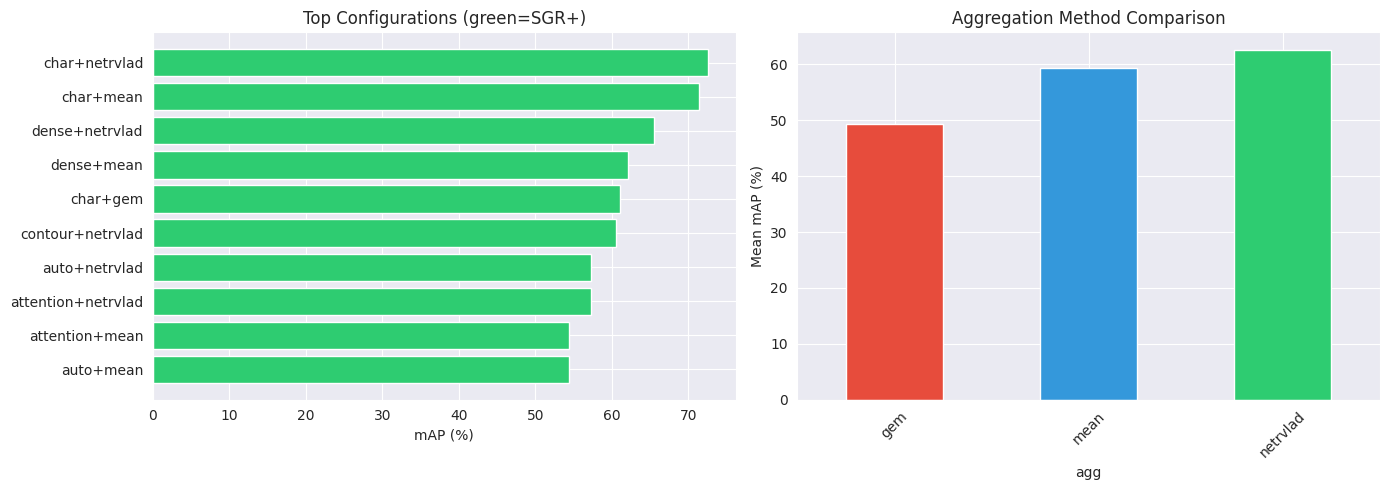

In [14]:
# ============================================================
# CELL 14: VISUALIZE ABLATION RESULTS
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 ABLATION RESULTS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if len(results_df) > 0:
    # Display top results
    logger.info(Colors.GREEN + '\n🏆 TOP 10 CONFIGURATIONS:' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╔═══════════════════════════════════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + '   ║ Rank │ Mode     │ Agg      │ Rerank   │  mAP   │ Top-1  │ Top-5  ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╠═══════════════════════════════════════════════════════════════╣' + Colors.RESET)
    for rank, (i, row) in enumerate(results_df.head(10).iterrows(), 1):
        logger.info(Colors.CYAN + f'   ║  {rank:2d}  │ {row["mode"]:8s} │ {row["agg"]:8s} │ {row["rerank"]:8s} │ '
                                  f'{row["mAP"] * 100:5.2f}% │ {row["Top1"] * 100:5.2f}% │ {row["Top5"] * 100:5.2f}% ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╚═══════════════════════════════════════════════════════════════╝' + Colors.RESET)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Top configurations bar chart
    ax1 = axes[0]
    top_n = min(10, len(results_df))
    top_results = results_df.head(top_n)
    labels = [f'{r["mode"]}+{r["agg"]}' for _, r in top_results.iterrows()]
    colors = ['#2ecc71' if r['rerank'] == 'sgr_plus' else '#3498db' for _, r in top_results.iterrows()]
    ax1.barh(range(top_n), top_results['mAP'] * 100, color=colors)
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(labels)
    ax1.set_xlabel('mAP (%)')
    ax1.set_title('Top Configurations (green=SGR+)')
    ax1.invert_yaxis()

    # 2. Aggregation comparison
    ax2 = axes[1]
    agg_means = results_df.groupby('agg')['mAP'].mean() * 100
    agg_means.plot(kind='bar', ax=ax2, color=['#e74c3c', '#3498db', '#2ecc71', '#9b59b6'])
    ax2.set_ylabel('Mean mAP (%)')
    ax2.set_title('Aggregation Method Comparison')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'hisir19_ablation_visualization.png', dpi=150)
    plt.show()
else:
    logger.error(Colors.RED + '❌ No results to display. Run ablation study first.' + Colors.RESET)

## Step 5: Full Test Set Evaluation

Evaluate the best configuration on the full test set (20,000 images).

In [17]:
# ============================================================
# CELL 15: FULL TEST SET EVALUATION
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '🎯 STEP 5: FULL TEST SET EVALUATION' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if best_ckpt and len(results_df) > 0:
    # Get best configuration
    best_config = results_df.iloc[0]
    logger.info(Colors.GREEN + f'\n🏆 Best configuration from ablation:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Mode: {best_config["mode"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Aggregation: {best_config["agg"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Reranking: {best_config["rerank"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   Validation mAP: {best_config["mAP"] * 100:.2f}%' + Colors.RESET)

    logger.info(Colors.MAGENTA + f'\n📊 Evaluating on full test set ({len(test_df)} images)...' + Colors.RESET)
    logger.warning(Colors.YELLOW + '   ⚠️ This may take a while due to large dataset size!' + Colors.RESET)

    # Build evaluation args
    test_args = [
        '--csv', str(HISIR19_TEST_CSV),
        '--checkpoint', str(best_ckpt),
        '--agg-type', best_config['agg'],
        '--mode', best_config['mode'],
        '--device', HISIR19_CONFIG['device'],
    ]

    if best_config['agg'] in ['netvlad', 'netrvlad']:
        test_args += ['--num-clusters', str(HISIR19_CONFIG['num_clusters'])]

    if best_config['rerank'] != 'none':
        test_args += ['--rerank', best_config['rerank']]

    sys.argv = ['eval_retrieval.py'] + test_args
    test_labels, test_paths, test_descs, test_metrics = eval_retrieval()

    # Save test descriptors
    np.save(RESULTS_DIR / 'hisir19_test_descs.npy', test_descs)

    logger.info(Colors.GREEN + '\n' + '=' * 50 + Colors.RESET)
    logger.info(Colors.GREEN + '🎯 FINAL TEST SET RESULTS' + Colors.RESET)
    logger.info(Colors.GREEN + '=' * 50 + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╔══════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Metric  │  Value                ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╠══════════════════════════════════╣' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  mAP     │  {test_metrics["mAP"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-1   │  {test_metrics["Top1"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-5   │  {test_metrics["Top5"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ║  Top-10  │  {test_metrics["Top10"] * 100:6.2f}%              ║' + Colors.RESET)
    logger.info(Colors.CYAN + f'   ╚══════════════════════════════════╝' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ Run ablation study first to determine best configuration.' + Colors.RESET)

10:19:37 | INFO     | ℹ️  
10:19:37 | INFO     | ℹ️  🎯 STEP 5: FULL TEST SET EVALUATION
10:19:37 | INFO     | ℹ️  ======================================================================
10:19:37 | INFO     | ℹ️  
🏆 Best configuration from ablation:
10:19:37 | INFO     | ℹ️     Mode: char
10:19:37 | INFO     | ℹ️     Aggregation: netrvlad
10:19:37 | INFO     | ℹ️     Reranking: sgr_plus
10:19:37 | INFO     | ℹ️     Validation mAP: 72.57%
10:19:37 | INFO     | ℹ️  
📊 Evaluating on full test set (20000 images)...
10:19:37 | WARNING  | ⚠️     ⚠️ This may take a while due to large dataset size!
10:19:38 | INFO     | ℹ️     Backbone from checkpoint: resnet34
10:19:38 | INFO     | ℹ️     Num clusters: 100 (from args)
10:19:38 | INFO     | ℹ️  🔧 Using netrvlad with 100 clusters
10:19:38 | INFO     | ℹ️  ============================================================
10:19:38 | INFO     | 🎯 Writer Retrieval Evaluation
10:19:38 | INFO     | ℹ️  =======================================================

Extracting:  16%|█▋        | 3254/20000 [04:49<22:00, 12.69it/s]

10:24:27 | WARNING  | ⚠️  No patches extracted from image of shape (804, 1600)


Extracting:  18%|█▊        | 3698/20000 [05:29<18:27, 14.72it/s]

10:25:07 | WARNING  | ⚠️  No patches extracted from image of shape (1600, 1182)


Extracting:  23%|██▎       | 4513/20000 [06:40<25:53,  9.97it/s]

10:26:18 | WARNING  | ⚠️  No patches extracted from image of shape (803, 1600)


Extracting:  23%|██▎       | 4696/20000 [06:57<24:03, 10.60it/s]

10:26:35 | WARNING  | ⚠️  No patches extracted from image of shape (1600, 1182)


Extracting:  52%|█████▏    | 10403/20000 [15:37<13:21, 11.98it/s]

10:35:15 | WARNING  | ⚠️  No patches extracted from image of shape (496, 1600)


Extracting:  63%|██████▎   | 12541/20000 [18:47<11:05, 11.21it/s]

10:38:25 | WARNING  | ⚠️  No patches extracted from image of shape (1600, 1112)


Extracting:  83%|████████▎ | 16521/20000 [24:44<04:12, 13.75it/s]

10:44:22 | WARNING  | ⚠️  No patches extracted from image of shape (510, 1600)


Extracting:  85%|████████▍ | 16931/20000 [25:21<05:50,  8.76it/s]

10:44:59 | WARNING  | ⚠️  No patches extracted from image of shape (1600, 1112)


Extracting:  98%|█████████▊| 19563/20000 [29:19<00:42, 10.27it/s]

10:48:57 | WARNING  | ⚠️  No patches extracted from image of shape (1097, 1600)


Extracting: 100%|██████████| 20000/20000 [29:57<00:00, 11.12it/s]


10:49:38 | INFO     | ℹ️     ✓ Extracted 20000 descriptors in 1798.0s
10:49:38 | INFO     | ℹ️     Average patches per page: 717.6
10:49:38 | INFO     | ℹ️     Descriptor dimension: 12800
10:49:38 | INFO     | ℹ️     Unique writers: 10069
10:49:38 | INFO     | ℹ️  
10:49:38 | INFO     | 📊 Computing retrieval metrics...
10:49:38 | INFO     | 📊 Computing retrieval metrics...
10:49:38 | INFO     | ℹ️     Queries: 20000
10:49:38 | INFO     | ℹ️     Descriptor dim: 12800
10:49:38 | INFO     | ℹ️     Unique writers: 10069
10:49:38 | INFO     | ℹ️     Computing similarity matrix...
10:50:07 | INFO     | ℹ️     ✓ Metrics computed in 28.3s
10:50:07 | INFO     | ℹ️  
10:50:07 | INFO     | ℹ️     ╔════════════════════════════════╗
10:50:07 | INFO     | ℹ️     ║  mAP:     40.46%              ║
10:50:07 | INFO     | ℹ️     ║  Top-1:   54.57%              ║
10:50:07 | INFO     | ℹ️     ║  Top-5:   69.23%              ║
10:50:07 | INFO     | ℹ️     ║  Top-10:  74.21%              ║
10:50:07 | INFO   

In [18]:
# ============================================================
# CELL 16: PER-CATEGORY ANALYSIS
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📊 STEP 6: PER-CATEGORY ANALYSIS' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

if 'test_labels' in dir() and 'test_descs' in dir():
    # Load category info
    test_df_with_source = pd.read_csv(TEST_GROUND_TRUTH)
    test_df_with_source.columns = ['filename', 'writer_id', 'source']

    # Map paths to categories
    path_to_source = {}
    for _, row in test_df_with_source.iterrows():
        path = str(HISIR19_TEST_DIR / row['filename'])
        path_to_source[path] = row['source']

    # Group results by category
    categories = test_df_with_source['source'].unique()

    logger.info(Colors.CYAN + '\n📈 Performance by document category:' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╔════════════════════════════════════════════╗' + Colors.RESET)
    logger.info(Colors.CYAN + '   ║ Category     │ Count  │  mAP   │  Top-1   ║' + Colors.RESET)
    logger.info(Colors.CYAN + '   ╠════════════════════════════════════════════╣' + Colors.RESET)

    for cat in categories:
        cat_mask = [path_to_source.get(p, '') == cat for p in test_paths]
        cat_indices = np.where(cat_mask)[0]
        if len(cat_indices) > 1:
            cat_labels = [test_labels[i] for i in cat_indices]
            cat_descs = test_descs[cat_indices]
            cat_mAP, cat_metrics = mean_average_precision(cat_labels, cat_descs)
            logger.info(
                Colors.CYAN + f'   ║ {cat:12s} │ {len(cat_indices):6d} │ {cat_mAP * 100:5.2f}% │ {cat_metrics["Top1"] * 100:6.2f}% ║' + Colors.RESET)

    logger.info(Colors.CYAN + '   ╚════════════════════════════════════════════╝' + Colors.RESET)
else:
    logger.error(Colors.RED + '❌ Run test set evaluation first.' + Colors.RESET)

10:53:56 | INFO     | ℹ️  
10:53:56 | INFO     | ℹ️  📊 STEP 6: PER-CATEGORY ANALYSIS
10:53:56 | INFO     | ℹ️  ======================================================================
10:53:57 | INFO     | ℹ️  
📈 Performance by document category:
10:53:57 | INFO     | ℹ️     ╔════════════════════════════════════════════╗
10:53:57 | INFO     | ℹ️     ║ Category     │ Count  │  mAP   │  Top-1   ║
10:53:57 | INFO     | ℹ️     ╠════════════════════════════════════════════╣
10:53:57 | INFO     | 📊 Computing retrieval metrics...
10:53:57 | INFO     | ℹ️     Queries: 10135
10:53:57 | INFO     | ℹ️     Descriptor dim: 12800
10:53:57 | INFO     | ℹ️     Unique writers: 2028
10:53:57 | INFO     | ℹ️     Computing similarity matrix...
10:54:08 | INFO     | ℹ️     ✓ Metrics computed in 11.0s
10:54:08 | INFO     | ℹ️  
10:54:08 | INFO     | ℹ️     ╔════════════════════════════════╗
10:54:08 | INFO     | ℹ️     ║  mAP:     49.02%              ║
10:54:08 | INFO     | ℹ️     ║  Top-1:   61.74%          

## Step 7: Summary and Conclusions

In [23]:
# ============================================================
# CELL 17: FINAL SUMMARY
# ============================================================
logger.info(Colors.BOLD_CYAN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '📋 FINAL SUMMARY' + Colors.RESET)
logger.info(Colors.BOLD_CYAN + '=' * 70 + Colors.RESET)

logger.info(Colors.GREEN + '\n🏛️ HISIR19 Historical Document Retrieval' + Colors.RESET)
logger.info(Colors.GRAY + '   ICDAR 2019 Competition Dataset' + Colors.RESET)
logger.info('')

logger.info(Colors.CYAN + '📊 Dataset:' + Colors.RESET)
logger.info(Colors.CYAN + f'   • Training: {len(train_df)} images, {len(train_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   • Validation: {len(val_split_df)} images, {len(val_writers)} writers' + Colors.RESET)
logger.info(Colors.CYAN + f'   • Test: {len(test_df)} images, {test_df["writer_id"].nunique()} writers' + Colors.RESET)
logger.info('')

if len(results_df) > 0:
    logger.info(Colors.GREEN + '🏆 Best Configuration:' + Colors.RESET)
    best = results_df.iloc[0]
    logger.info(Colors.CYAN + f'   • Mode: {best["mode"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   • Aggregation: {best["agg"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   • Reranking: {best["rerank"]}' + Colors.RESET)
    logger.info(Colors.CYAN + f'   • Validation mAP: {best["mAP"] * 100:.2f}%' + Colors.RESET)
    logger.info('')

if 'test_metrics' in dir():
    logger.info(Colors.GREEN + '🎯 Test Set Performance:' + Colors.RESET)
    logger.info(Colors.CYAN + f'   • mAP: {test_metrics["mAP"] * 100:.2f}%' + Colors.RESET)
    logger.info(Colors.CYAN + f'   • Top-1: {test_metrics["Top1"] * 100:.2f}%' + Colors.RESET)
    logger.info(Colors.CYAN + f'   • Top-5: {test_metrics["Top5"] * 100:.2f}%' + Colors.RESET)
    logger.info('')

logger.info(Colors.CYAN + '💾 Saved Files:' + Colors.RESET)
for f in RESULTS_DIR.glob('hisir19_*'):
    logger.info(Colors.CYAN + f'   • {f.name}' + Colors.RESET)

logger.info(Colors.GREEN + '\n' + '=' * 70 + Colors.RESET)
logger.info(Colors.GREEN + '✅ HISIR19 PIPELINE COMPLETE' + Colors.RESET)
logger.info(Colors.GREEN + '=' * 70 + Colors.RESET)

10:54:40 | INFO     | ℹ️  
10:54:40 | INFO     | ℹ️  📋 FINAL SUMMARY
10:54:40 | INFO     | ℹ️  ======================================================================
10:54:40 | INFO     | ℹ️  
🏛️ HISIR19 Historical Document Retrieval
10:54:40 | INFO     | ℹ️     ICDAR 2019 Competition Dataset
10:54:40 | INFO     | ℹ️  
10:54:40 | INFO     | ℹ️  📊 Dataset:
10:54:40 | INFO     | ℹ️     • Training: 968 images, 416 writers
10:54:40 | INFO     | ℹ️     • Validation: 232 images, 104 writers
10:54:40 | INFO     | ℹ️     • Test: 20000 images, 10069 writers
10:54:40 | INFO     | ℹ️  
10:54:40 | INFO     | ℹ️  🏆 Best Configuration:
10:54:40 | INFO     | ℹ️     • Mode: char
10:54:40 | INFO     | ℹ️     • Aggregation: netrvlad
10:54:40 | INFO     | ℹ️     • Reranking: sgr_plus
10:54:40 | INFO     | ℹ️     • Validation mAP: 72.57%
10:54:40 | INFO     | ℹ️  
10:54:40 | INFO     | ℹ️  🎯 Test Set Performance:
10:54:40 | INFO     | ℹ️     • mAP: 40.46%
10:54:40 | INFO     | ℹ️     • Top-1: 54.57%
10:54